<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190656 entries, 0 to 190655
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dateTime           190656 non-null  object 
 1   temperature        170187 non-null  float64
 2   salinity           166470 non-null  float64
 3   condolence         178774 non-null  float64
 4   electricPotential  11835 non-null   float64
dtypes: float64(4), object(1)
memory usage: 7.3+ MB


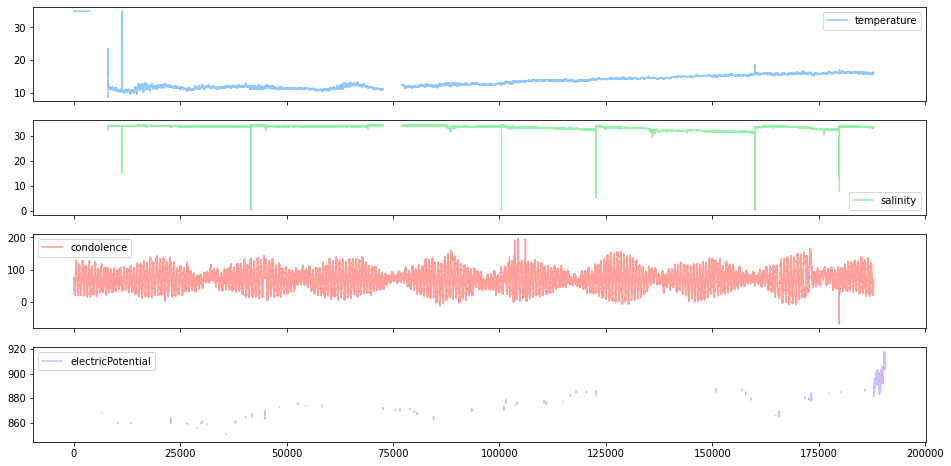

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import os
for dirname, _, filenames in os.walk('./Busan_Data/Gwangan/광안대교앵커리지1_20210101_20210731.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

plt.style.use(['seaborn-pastel'])        
        
df = pd.read_csv('./Busan_Data/Gwangan/광안대교앵커리지1_20210101_20210731.csv')

df.rename(columns = {"Unnamed: 0" : "Day"},inplace = True)

df.info()

df.plot(figsize=(16,8), subplots=True)
plt.show()

In [3]:
df_test = df.set_index(pd.to_datetime(df['dateTime']))

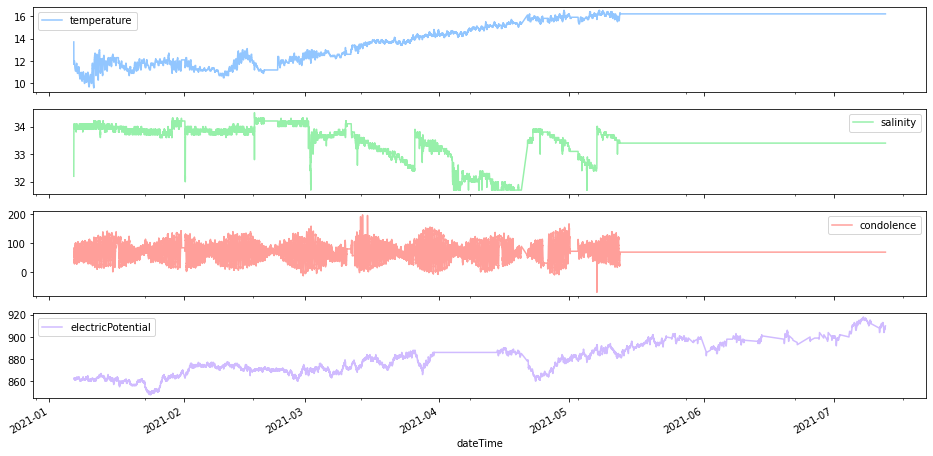

In [4]:
df_test['salinity'].fillna(method='pad', inplace=True)
df_test['condolence'].fillna(method='pad', inplace=True)
df_test['temperature'].fillna(method='pad', inplace=True)
df_test['electricPotential'].fillna(method='pad', inplace=True)
df_test['dateTime'].fillna(method='pad', inplace=True)
df_test['salinity'].fillna(method='bfill', inplace=True)
df_test['condolence'].fillna(method='bfill', inplace=True)
df_test['temperature'].fillna(method='bfill', inplace=True)
df_test['electricPotential'].fillna(method='bfill', inplace=True)


##이상값 처리

quartiles = np.percentile(df_test['salinity'],[25,50,75])
IQR = (quartiles[2]-quartiles[0])
search_df = df_test[(df_test['salinity'] < (quartiles[0] - 1.5 * IQR)) | (df_test['salinity'] > (quartiles[2] + 1.5 * IQR))]
df_test = df_test.drop(search_df.index,axis=0)
quartiles = np.percentile(df_test['temperature'],[25,50,75])
IQR = (quartiles[2]-quartiles[0])
search_df = df_test[(df_test['temperature'] < (quartiles[0] - 1.5 * IQR)) | (df_test['temperature'] > (quartiles[2] + 1.5 * IQR))]
df_test = df_test.drop(search_df.index,axis=0)

df_test.plot(figsize=(16,8), subplots=True)
plt.show()
#df_test2.info()

In [12]:
df_test = df_test.drop('dateTime', axis=1)
df_test.head()

,temperature,salinity,condolence,electricPotential
dateTime,,,,
2021-01-06 16:03:00,13.7,32.2,83.0,862.0
2021-01-06 16:04:00,12.9,32.9,82.0,862.0
2021-01-06 16:05:00,12.4,33.3,81.0,862.0
2021-01-06 16:06:00,12.1,33.6,80.0,862.0
2021-01-06 16:07:00,11.9,33.8,78.0,862.0


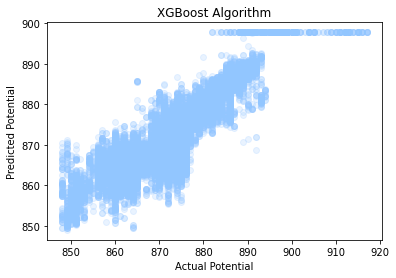

MSE : 15.424, RMSE : 3.927
Variance score : 0.852


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb
df_testq = df_test.astype('float64')
y_data = df_testq['electricPotential']
x_data = df_testq[['salinity','condolence','temperature']]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, test_size=0.2, random_state=12)

xgb_mod = xgb.XGBRegressor(
   booster='gbtree',
    gamma=10,     
    reg_lambda=10,
    reg_alpha=10,
    min_child_weight=10,
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=3,
    n_estimators=10000,                                                                    
    subsample=0.8,
    random_state=12
    
) 

xgb_mod.fit(x_train, y_train)
xgb_predictions = xgb_mod.predict(x_test)

lr = LinearRegression()
lr.fit(x_train, y_train)
y_preds = lr.predict(x_test)

plt.scatter(y_test, xgb_predictions, alpha=0.2)
plt.xlabel("Actual Potential")
plt.ylabel("Predicted Potential")
plt.title("XGBoost Algorithm")
plt.show()

mse = mean_squared_error(y_test, xgb_predictions)
rmse = np.sqrt(mse)

print('MSE : {0:.3F}, RMSE : {1:.3F}'.format(mse,rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test,xgb_predictions)))

dt_clf = DecisionTreeClassifier(random_state=12)
rf_clf = RandomForestClassifier(random_state=12)
lr_clf = LogisticRegression(solver='lbfgs', max_iter=4000)

#dt_clf.fit(x_train, y_train)
#dt_pred = dt_clf.predict(x_test)
#print('DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))

#rf_clf.fit(x_train, y_train)
#rf_pred = rf_clf.predict(x_test)
#print('RandomForestClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))

#LogisticRegression 학습/예측/평가
#lr_clf.fit(x_train, y_train)
#lr_pred = lr_clf.predict(x_test)
#print('LogisticRegression 정확도: {0:.4f}'.format(accuracy_score(y_test, lr_pred)))